# ICME rate for solar cycle 25 and PSP flux rope double crossings


### jupyter notebook 2 of 2 for the paper Möstl et al. (2020, ApJ)

psp_3dcore.ipynb, psp_3dcore.py
https://github.com/helioforecast/Papers/tree/master/Moestl2020_PSP_rate
simulates PSP double crossings of ICME flux ropes


Authors: C. Möstl, Andreas J. Weiss, IWF Graz, Austria; twitter @chrisoutofspace; https://github.com/cmoestl

For installation of a conda environment to run this code and how to download the data into a directory specified in config.py, see instructions in README.md of the github repo. Conda dependencies are listed under environment.yml, and pip in requirements.txt. Plots are saved in results/plots_rate/ as png and pdf.



---

**MIT LICENSE**

Copyright 2020, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# 5 3DCORE modeling of PSP double crossings

Here 3DCORE is used to model synthetic observations of expanding flux ropes close to the Sun

In [16]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
import astropy
import astropy.constants as const
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib
import heliopy.spice as spice
import heliopy.data.spice as spicedata
import multiprocessing
import sunpy
import sunpy.time
from sunpy.time import parse_time


import scipy

import py3dcore
import heliosat

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from matplotlib import rc


#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
os.system('jupyter nbconvert --to script psp_3dcore.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots_rate'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
    
    
animdirectory='results/plots_rate/anim'
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)
    
animdirectory2='results/plots_rate/anim2'
if os.path.isdir(animdirectory2) == False: os.mkdir(animdirectory2)
    
animdirectory3='results/plots_rate/anim3'
if os.path.isdir(animdirectory3) == False: os.mkdir(animdirectory3)
    
#rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [2]:
############### Model Settings
t_launch = datetime.datetime(2022, 6, 1, 20)

iparams_arr = np.array([[
    0,      # time offset
    145,    # l_1 (logitude)
    2.5,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    1,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    400,    # v_0 (initial velocty in)
    -5,      # tau (magnetic field twist)
    1,      # b_s (magnetic field scaling parameter)
    12,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


TP_A =  t_launch + datetime.timedelta(hours=4)
TP_B =  t_launch + datetime.timedelta(hours=26)

C_A = "xkcd:red"
C_B = "xkcd:blue"

C0 = "xkcd:black"
C1 = "xkcd:magenta"
C2 = "xkcd:orange"
C3 = "xkcd:azure"



class PSP_FIXED(heliosat.PSP):
    def __init__(self, t_fixed, **kwargs):
        self.t_fixed = t_fixed

        super(PSP_FIXED, self).__init__(**kwargs)

    def trajectory(self, t, frame, **kwargs):
        return super().trajectory(t=[self.t_fixed] * len(t), frame=frame, **kwargs)

setattr(heliosat, "PSP_FIXED", PSP_FIXED)

In [3]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    #time resolution in seconds
    #t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    
    #time resolution in minutes
    res_in_days=1/(24*60.)    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    #print('data points',len(t_s))
    
    
    o_s = inst.trajectory(t_s, frame=frame)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b


#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    
    
    #draw sun        
    ls = LightSource(azdeg=320, altdeg=40)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
    
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .12)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,zorder=3)

def plot_3dcore_field(ax, obj, steps=500, step_size=0.005, **kwargs):
    q0 = kwargs.get("q0", np.array([1, .1, np.pi/2], dtype=np.float32)).astype(np.float32)

    fl = obj.visualize_fieldline(q0, steps=steps, step_size=step_size)

    ax.plot(*fl.T, **kwargs)

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        #ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
        
def plot_shift(axis,extent,cx,cy,cz):
    #shift center of plot
    axis.set_xbound(cx-extent, cx+extent)
    axis.set_ybound(cy-extent, cy+extent)
    axis.set_zbound(cz-extent*0.75, cz+extent*0.75)

## **Figure 5** 

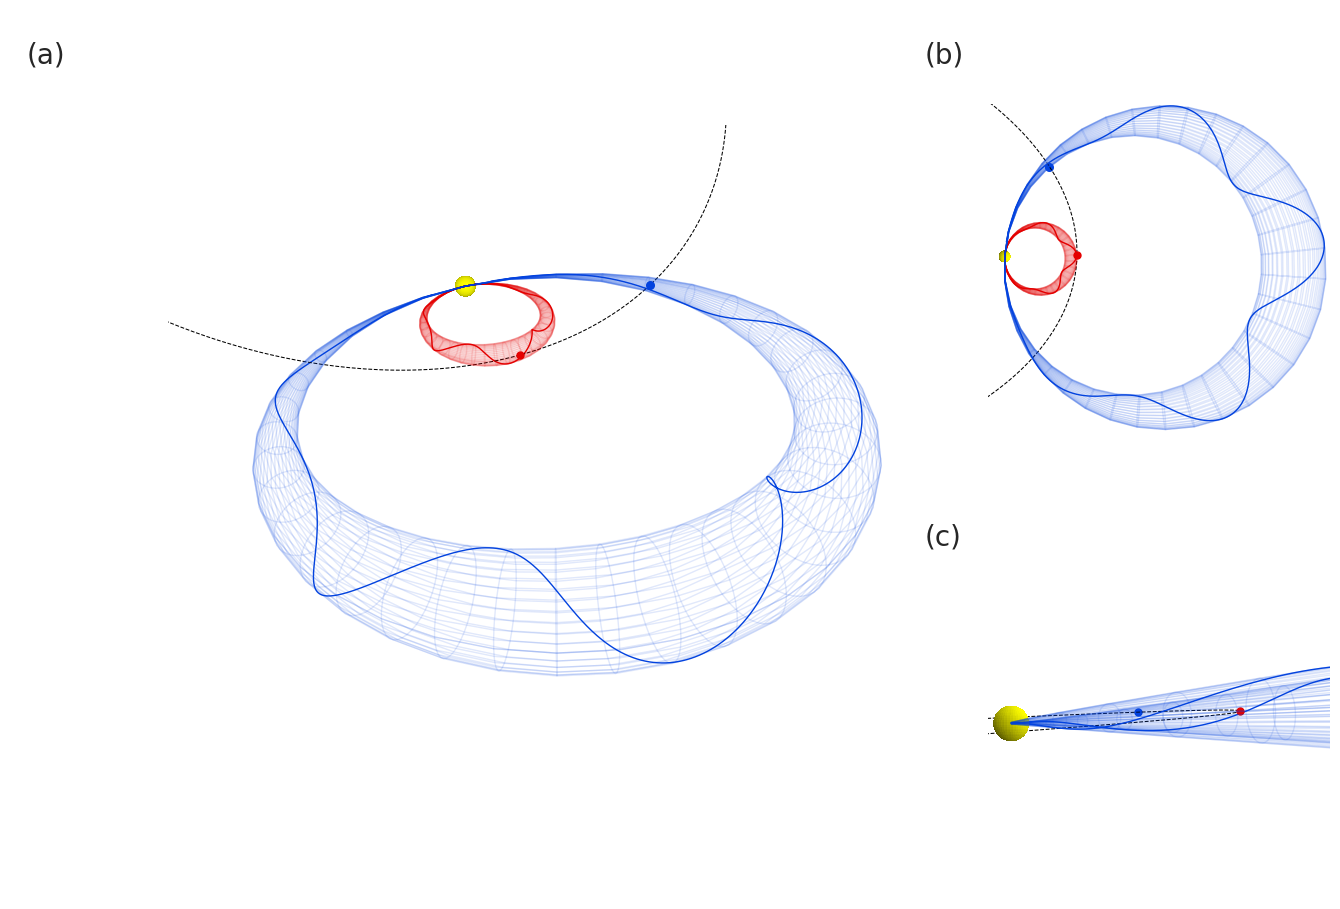

In [4]:
sns.set_style('whitegrid')

fig = plt.figure(figsize=(15, 11),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((2, 3), (0, 0),rowspan=2,colspan=2,projection='3d')  
ax2 = plt.subplot2grid((2, 3), (0, 2),projection='3d')  
ax3 = plt.subplot2grid((2, 3), (1, 2),projection='3d')  
#ax4 = plt.subplot2grid((3, 3), (2, 2),projection='3d')  


######### tilted view
plot_configure(ax1, view_azim=125, view_elev=40, view_radius=.08)

plot_3dcore(ax1, model_obj, TP_A, color=C_A)
plot_3dcore_field(ax1, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax1, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax1, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax1, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
plot_traj(ax1, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)

#dotted trajectory
plot_traj(ax1, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

#shift center
plot_shift(ax1,0.11,-0.05,0.0,-0.1)


########### top view panel
plot_configure(ax2, view_azim=145-90, view_elev=90, view_radius=.08)
plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
plot_3dcore(ax2, model_obj, TP_A, color=C_A)
plot_3dcore_field(ax2, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax2, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax2, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax2, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
plot_shift(ax2,0.09,-0.11,0.08,0.0)


############### edge on view panel
plot_configure(ax3, view_azim=145-90, view_elev=0, view_radius=.04)
plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
#plot_3dcore(ax3, model_obj, TP_A, color=C_A)
#plot_3dcore_field(ax3, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
plot_traj(ax3, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax3, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax3, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.0, ls="-")
plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.0)

plot_shift(ax3,0.03,-0.05,0.0,0.0)


############### face on view panel
#plot_configure(ax4, view_azim=145, view_elev=0, view_radius=.12)
#plot_traj(ax4, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
#plot_3dcore(ax4, model_obj, TP_A, color=C_A)
#plot_3dcore_field(ax4, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.0, ls="-")
#plot_traj(ax4, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)
#plot_3dcore(ax4, model_obj, TP_B, color=C_B)
#plot_3dcore_field(ax4, model_obj, color=C_B, steps=850, step_size=0.001, lw=1.0, ls="-")
#plot_traj(ax4, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)
#plot_shift(ax3,0.025,-0.03,0.0,0.0)


#panel labels
plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(b)',[0.69,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(c)',[0.69,0.40],xycoords='figure fraction',fontsize=20)

plt.savefig('results/plots_rate/fig5_3dcore_visual.pdf',bbox_inches='tight')
plt.savefig('results/plots_rate/fig5_3dcore_visual.png', dpi=300,bbox_inches='tight')



### measure magnetic fields

In [5]:
t1, btot1, bxyz1 = measure(model_obj, "PSP",  t_launch, TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN")
t2, btot2, bxyz2 = measure(model_obj, "PSP",  t_launch, TP_B  + datetime.timedelta(hours=12), frame="ECLIPJ2000", bframe="SPP_RTN")
t3, btot3, bxyz3 = measure(model_obj, "PSP", t_launch, TP_B  + datetime.timedelta(hours=72), frame="ECLIPJ2000", bframe="SPP_RTN")

tf, btotf, bxyzf = measure(model_obj, "PSP_FIXED", t_launch, TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN", satparams=TP_A)

## **Figure 6** 

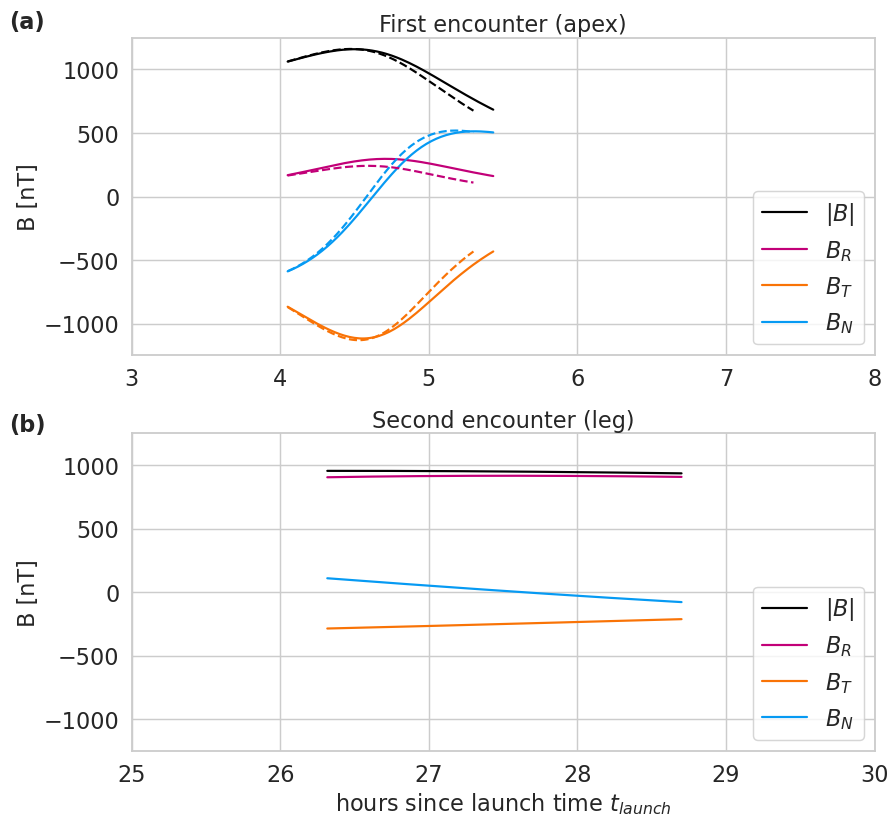

In [6]:
sns.set_context('talk')
sns.set_style('whitegrid')

fsize1=23

#simulation time in hours
simtime1=np.round((parse_time(t1).plot_date-parse_time(t_launch).plot_date)*24,4)

fig = plt.figure(figsize=(13, 12),dpi=70)

ax1 = fig.add_subplot(211)
ax1.set_title("First encounter (apex)",fontsize=fsize1)

ax1.plot(simtime1, btot1, color=C0, label="$|B|$")
ax1.plot(simtime1, bxyz1[:, 0], color=C1, label="$B_R$")
ax1.plot(simtime1, bxyz1[:, 1], color=C2, label="$B_T$")
ax1.plot(simtime1, bxyz1[:, 2], color=C3, label="$B_N$")

ax1.plot(simtime1, btotf, color=C0, linestyle='--')
ax1.plot(simtime1, bxyzf[:, 0], color=C1, linestyle='--')
ax1.plot(simtime1, bxyzf[:, 1], color=C2, linestyle='--')
ax1.plot(simtime1, bxyzf[:, 2], color=C3, linestyle='--')

ax1.legend(loc="lower right", fontsize=fsize1,ncol=1)
ax1.set_ylabel('B [nT]',fontsize=fsize1)
ax1.set_ylim(-1250,1250)
ax1.set_xlim(3,8)
#plt.xlim(datetime.datetime(2022,6,1,23,0),datetime.datetime(2022,6,2,4,0))
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax1.tick_params(labelsize=fsize1)

#ax1.set_xlabel('hours since launch time $t_0$')
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
#ax1.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(500))



#simulation time in hours
simtime2=np.round((parse_time(t2).plot_date-parse_time(t_launch).plot_date)*24,4)

ax2 = fig.add_subplot(212)
ax2.set_title("Second encounter (leg)",fontsize=fsize1)

ax2.plot(simtime2, btot2, color=C0, label="$|B|$")
ax2.plot(simtime2, bxyz2[:, 0], color=C1, label="$B_R$")
ax2.plot(simtime2, bxyz2[:, 1], color=C2, label="$B_T$")
ax2.plot(simtime2, bxyz2[:, 2], color=C3, label="$B_N$")

ax2.legend(loc="lower right", fontsize=fsize1,ncol=1)
#ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax2.set_xlabel('simulation time',fontsize=fsize1)
ax2.set_ylabel('B [nT]',fontsize=fsize1)
ax2.set_ylim(-1250,1250)
ax2.set_xlim(3+22,8+22)
#plt.xlim(datetime.datetime(2022,6,2,21,0),datetime.datetime(2022,6,3,2,0))


ax2.set_xlabel('hours since launch time $t_{launch}$')
ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
#ax1.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(500))

ax2.tick_params(labelsize=fsize1)

plt.tight_layout()

plt.annotate('(a)',[0.01,0.965],xycoords='figure fraction',weight='bold',fontsize=fsize1)
plt.annotate('(b)',[0.01,0.475],xycoords='figure fraction',weight='bold',fontsize=fsize1)

plt.savefig('results/plots_rate/fig6_3dcore_components.pdf', dpi=300)
plt.savefig('results/plots_rate/fig6_3dcore_components.png', dpi=300)

### visualize PSP trajectory through the flux rope

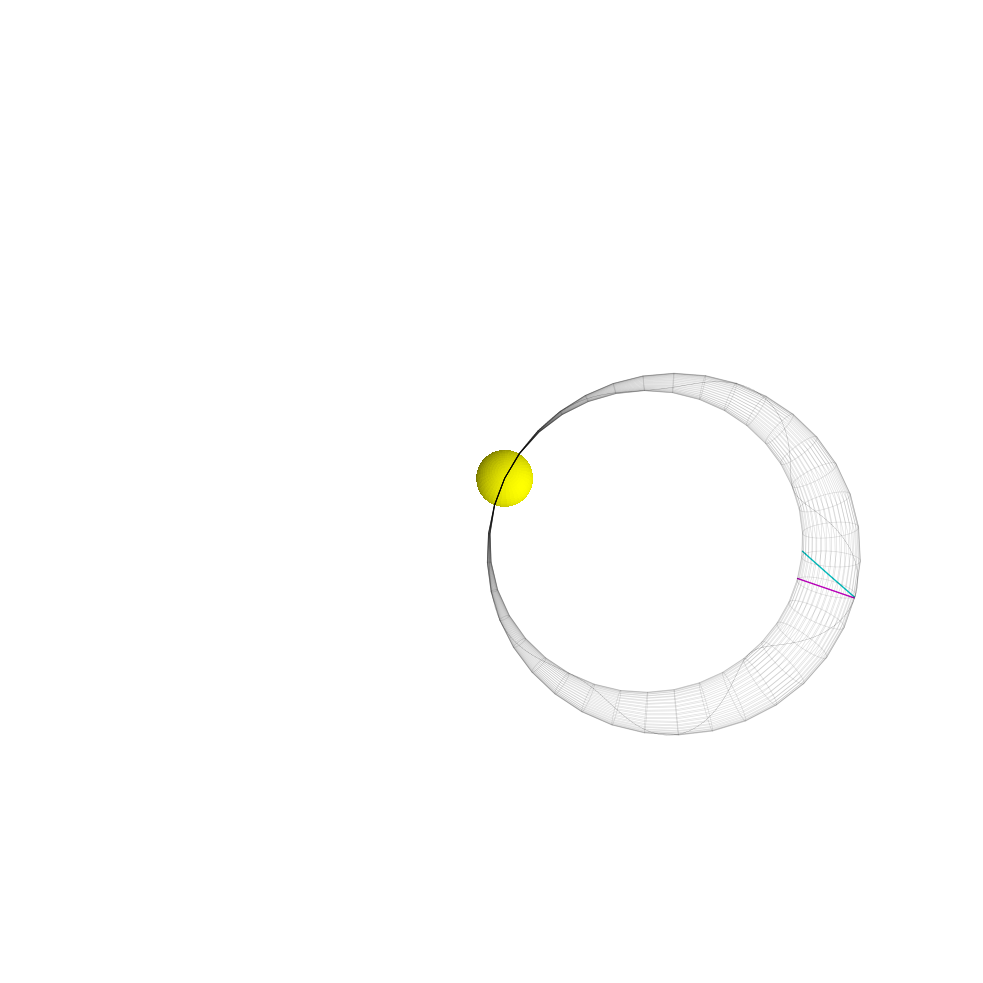

In [7]:
def plot_reconstruction(ax, obj, qs, **kwargs):

    ss = []

    for i in range(len(qs)):
        q = np.array([qs[i]])
        s = np.empty_like(q)

        obj.transform_qs(s, q)

        ss.append(s[0])

    ss = np.array(ss)

    ax.plot(*ss.T, **kwargs)

def reconstruct_path(obj, sat, t0, t1, frame="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    o_s = inst.trajectory(t_s, frame=frame)

    qs = []

    for i in range(len(t_s)):
        s = np.array([o_s[i]])
        q = np.empty_like(s)

        obj.propagate(t_s[i])
        obj.transform_sq(s, q)

        if q[0][0] < 1.0:
            qs.append(np.copy(q[0]))

    return qs

QPATH_PSP = reconstruct_path(model_obj, "PSP", TP_A - datetime.timedelta(hours=3), TP_A  + datetime.timedelta(hours=3), frame="ECLIPJ2000")
QPATH_PSP_FIXED = reconstruct_path(model_obj, "PSP_FIXED", TP_A - datetime.timedelta(hours=3), TP_A  + datetime.timedelta(hours=3), frame="ECLIPJ2000", satparams=TP_A)

fig = plt.figure(figsize=(20, 20),dpi=50)
ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=80, view_elev=75, view_radius=.05)

plot_3dcore(ax, model_obj, TP_A, color=C0)
plot_3dcore_field(ax, model_obj, color=C0, steps=400, step_size=0.0005, lw=.5, ls=":")

plot_reconstruction(ax, model_obj, QPATH_PSP, color="c", ls="-", lw=2)
plot_reconstruction(ax, model_obj, QPATH_PSP_FIXED, color="m", ls="-", lw=2)

plt.tight_layout()

## **Figure 5** animation for paper

best done on a server with multiprocessing - set nr_of_processes_used to low values (2,4) when runnning locally on a laptop or desktop


In [26]:
#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processes

nr_of_processes_used=100

print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)


sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})


def plot_3dcore2(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .10)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,linewidth=2.0,zorder=3)
    

def make_frame2(k):
    
    fig = plt.figure(52,figsize=(19.2, 10.8),dpi=100)
    
    #define subplot grid
    ax1 = plt.subplot2grid((3, 3), (0, 0),rowspan=3,colspan=2,projection='3d')  
    ax2 = plt.subplot2grid((3, 3), (0, 2),projection='3d')  
    ax3 = plt.subplot2grid((3, 3), (1, 2),projection='3d')  
    #ax4 = plt.subplot2grid((3, 3), (2, 0))  

    #manually set axes positions
    #https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
    ax1.set_position([0,0,0.6,1], which='both')
    ax2.set_position([0.65,0.35,0.35,0.65], which='both')
    ax3.set_position([0.6,0,0.4,0.4], which='both')
    #ax4.set_position([0.1,0.1,0.5,0.25], which='both')

    
    steps1=400+k*60
    stepsize1=0.0005

    ######### tilted view
    plot_configure(ax1, view_azim=125, view_elev=40, view_radius=.08)

    #solar equatorial plane
    #for p in np.arange(-1,1,0.05):
    #    ax1.plot([-1,1],[p,p],[0,0],lw=0.5,color='black', alpha=0.4,linestyle='--',zorder=0 )
    #    ax1.plot([p,p],[-1,1],[0,0],lw=0.5,color='black', alpha=0.4,linestyle='--',zorder=0 )
    

    plot_3dcore2(ax1, model_obj, tlist[k], color=C_A)
    #plot_3dcore_field(ax1, model_obj, color=C_A, steps=steps1, step_size=stepsize1, lw=1.0, ls="-")

    plot_traj(ax1, "PSP",  tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax1, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

    #shift center
    plot_shift(ax1,0.11,-0.05,0.0,-0.1)

    ########### top view panel
    plot_configure(ax2, view_azim=145-90, view_elev=90, view_radius=.08)

    plot_3dcore2(ax2, model_obj,  tlist[k], color=C_A)
    #plot_3dcore_field(ax2, model_obj, color=C_A, steps=steps1,step_size=stepsize1, lw=1.0, ls="-")

    plot_traj(ax2, "PSP",tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
    plot_shift(ax2,0.09,-0.11,0.08,0.0)


    ############### edge on view panel
    plot_configure(ax3, view_azim=145-90, view_elev=0, view_radius=.04)

    plot_3dcore2(ax3, model_obj,  tlist[k], color=C_A)
    #plot_3dcore_field(ax3, model_obj, color=C_A, steps=steps1, step_size=stepsize1, lw=1.0, ls="-")

    plot_traj(ax3, "PSP", tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

    plot_shift(ax3,0.03,-0.05,0.0,0.0)    
    
    
    ############################## magnetic field panel
    #ax4.plot(simtime3, btot3, color=C0, label="$|B|$")
    #ax4.plot(simtime3, bxyz3[:, 0], color=C1, label="$B_R$")
    #ax4.plot(simtime3, bxyz3[:, 1], color=C2, label="$B_T$")
    #ax4.plot(simtime3, bxyz3[:, 2], color=C3, label="$B_N$")

    
    #ax4.legend(loc="lower right", fontsize=12,ncol=4,edgecolor='white')
    #ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
    #ax4.set_ylabel('B [nT]')
    #ax4.set_ylim(-1300,1300)
    #ax4.set_xlim(datetime.datetime(2022,6,1,23,0),datetime.datetime(2022,6,3,4,0))

    #line at current time
    #ax4.plot([frametime[k],frametime[k]], [-2000,2000], color='black',linewidth=1,alpha=0.8)
    #ax4.set_xlabel('hours since launch time')
    #ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
    #ax4.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    #ax4.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(500))
    #ax4.set_xlim(0,30)
    #ax4.grid(True)
    

    #write hours since launch time 
    plt.annotate('$t_{launch}$ +',[0.45,0.15],ha='center',xycoords='figure fraction',fontsize=20)
    plt.annotate(str(frametime[k]),[0.5,0.15],ha='center',xycoords='figure fraction',fontsize=20)
    plt.annotate('hours',[0.54,0.15],ha='center',xycoords='figure fraction',fontsize=20)
   

    #panel labels
    #plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(b)',[0.59,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(c)',[0.59,0.40],xycoords='figure fraction',fontsize=20)

    framestr = '%05i' % (k)  
    plt.savefig(animdirectory2+'/3dcore_psp_'+framestr+'.jpg',dpi=100)
    print('frame:', k)
    plt.close(52)



################## make animation    

#time for the animation as list
tlist=[]
for i in np.arange(1,2200,5):    
    tlist.append(t_launch+datetime.timedelta(minutes=float(i)))
    
print('number of frames',len(tlist))
#sns.set_style('whitegrid')


#simulation time since launch
frametime=np.round((parse_time(tlist).plot_date-parse_time(t_launch).plot_date)*24,1)

simtime3=np.round((parse_time(t3).plot_date-parse_time(t_launch).plot_date)*24,4)

#clock computing time
starttime1=time.time()

######## make frames
#make_frame2(40)


############################## multi

#run multiprocessing pool to make all movie frames, depending only on frame number
pool = multiprocessing.Pool(processes=nr_of_processes_used)
input=[i for i in range(len(tlist))]
pool.map(make_frame2, input)
pool.close()
# pool.join()


################################## single

#make all frames
#for k in np.arange(1,len(tlist)):
#    make_frame2(k)
    
#######################################    

os.system('ffmpeg -r 25 -i '+animdirectory2+'/3dcore_psp_%05d.jpg -b 5000k -r 25 '+outputdirectory+'/moestl2020_3dcore_psp_figure_5.mp4 -y -loglevel quiet')

print('movie finished in',np.round((time.time()-starttime1)/60,2),' minutes')

Using multiprocessing, nr of cores 128 with nr of processes used:  100
number of frames 440
frame: 172
frame: 196
frame: 106frame:
 frame: 174104

frame: 40
frame: frame: 184120

frame: 130
frame: 118frame:frame:frame:
 frame: frame:14
  140 
12frame:72
 
82
152
frame: frame:90frame: frame: 48
frame: 
170 64
52

frame: 42
frame: 134frame:
 6
frame: 10frame:
 94
frame: 74
frame: 18frame:
 84
frame: 46
frame: 144frame:
 190frame:frame: 
178frame: frame:4
 
198
 16
frame: 80
frame: frame:frame:164frame: frame:frame:
  34 
 6054142

107frame:
 frame:frame:
58 
 138
192
frame: 73
frame: 102frame:
 100frame:
 frame:frame: frame:62  5688
26
frame:

frame: 112
 frame:175 frame:
86
 119frame:frame: 
 16613

frame: 148
frame:frame: 41frame: 
frame:96
  141
197frame:frame:
  105frame:
 156126

frame: frame:76frame:
frame:  38 124

70
frame:frame:frame: 11 
182
frame:  frame:20frame:179 
 15815frame:

frame:  65
194

frame: 75
frame:frame:frame:  2432 
frame:frame:frame:   
210850121


frame:frame

## **Figure 5** animation for paper with in situ panel and 3d field lines (available on figshare)

In [30]:
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})

#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=30



#for field line plots stepsize and initial point for drawing    
field_stepsize=0.0005    
q1=np.array([1, .1, np.pi/2])



def visualize_fieldline_dpsi(obj, q0, dpsi=np.pi, index=0, step_size=0.01):
        """Integrates along the magnetic field lines starting at a point q0 in (q) coordinates and
        returns the field lines in (s) coordinates.
        Parameters
        ----------
        q0 : np.ndarray
            Starting point in (q) coordinates.
        dpsi: float
            Delta psi to integrate by, default np.pi
        index : int, optional
            Model run index, by default 0.
        step_size : float, optional
            Integration step size, by default 0.01.
        Returns
        -------
        np.ndarray
            Integrated magnetic field lines in (s) coordinates.
        """
        # only implemented in cpu mode
        _tva = np.empty((3,), dtype=obj.dtype)
        _tvb = np.empty((3,), dtype=obj.dtype)
        obj.g(q0, _tva, obj.iparams_arr[index], obj.sparams_arr[index], obj.qs_xs[index])
        fl = [np.array(_tva, dtype=obj.dtype)]
        def iterate(s):
            obj.f(s, _tva, obj.iparams_arr[index], obj.sparams_arr[index], obj.qs_sx[index])
            obj.h(_tva, _tvb, obj.iparams_arr[index], obj.sparams_arr[index], obj.qs_xs[index], bounded=False)
            return _tvb / np.linalg.norm(_tvb)
        psi_pos = q0[1]
        dpsi_count = 0
        while dpsi_count < dpsi:
            # use implicit method and least squares for calculating the next step
            sol = getattr(scipy.optimize.least_squares(
                lambda x: x - fl[-1] - step_size *
                iterate((x.astype(obj.dtype) + fl[-1]) / 2),
                fl[-1]), "x")
            fl.append(np.array(sol.astype(obj.dtype)))
            obj.f(fl[-1], _tva, obj.iparams_arr[index], obj.sparams_arr[index],
                   obj.qs_sx[index])
            dpsi_count += np.abs(psi_pos - _tva[1])
            psi_pos = _tva[1]
        fl = np.array(fl, dtype=obj.dtype)
        return fl



   
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = visualize_fieldline_dpsi(model_obj,q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    
    

def plot_3dcore2(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .10)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,linewidth=2.0,zorder=3)
    
    

def make_frame2(k):
    
    fig = plt.figure(52,figsize=(19.2, 10.8),dpi=100)
    
    #define subplot grid
    ax1 = plt.subplot2grid((3, 3), (0, 0),rowspan=2,colspan=2,projection='3d')  
    ax2 = plt.subplot2grid((3, 3), (0, 2),projection='3d')  
    ax3 = plt.subplot2grid((3, 3), (1, 2),projection='3d')  
    ax4 = plt.subplot2grid((3, 3), (2, 0))  

    
    
    #ax4 = plt.subplot2grid((3, 3), (2, 2),projection='3d')  

    #manually set axes positions
    #https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_position.html#matplotlib.axes.Axes.set_position
    ax1.set_position([0,0,0.6,1], which='both')
    ax2.set_position([0.65,0.35,0.35,0.65], which='both')
    ax3.set_position([0.55,0,0.4,0.35], which='both')
    ax4.set_position([0.1,0.1,0.5,0.25], which='both')


    
    ######### tilted view
    plot_configure(ax1, view_azim=125, view_elev=40, view_radius=.08)

    #solar equatorial plane
    #for p in np.arange(-1,1,0.05):
    #    ax1.plot([-1,1],[p,p],[0,0],lw=0.5,color='black', alpha=0.4,linestyle='--',zorder=0 )
    #    ax1.plot([p,p],[-1,1],[0,0],lw=0.5,color='black', alpha=0.4,linestyle='--',zorder=0 )

    
    

    plot_3dcore2(ax1, model_obj, tlist[k], color='mediumslateblue')
    plot_3dcore_field(ax1, model_obj, color=C_A, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

    plot_traj(ax1, "PSP",  tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax1, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

    #shift center
    plot_shift(ax1,0.11,-0.05,0.0,-0.1)


    ########### top view panel
    plot_configure(ax2, view_azim=145-90, view_elev=90, view_radius=.08)

    plot_3dcore2(ax2, model_obj,  tlist[k], color='mediumslateblue')
    plot_3dcore_field(ax2, model_obj, color=C_A, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

    plot_traj(ax2, "PSP",tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax2, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
    plot_shift(ax2,0.09,-0.11,0.08,0.0)


    ############### edge on view panel
    plot_configure(ax3, view_azim=145-90, view_elev=0, view_radius=.04)

    plot_3dcore2(ax3, model_obj,  tlist[k], color='mediumslateblue')
    plot_3dcore_field(ax3, model_obj, color=C_A, step_size=field_stepsize, lw=1.1, ls="-",q0=q1)

    plot_traj(ax3, "PSP", tlist[k], frame="ECLIPJ2000", color='k')
    plot_traj(ax3, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

    plot_shift(ax3,0.03,-0.05,0.0,0.0)    
    
    
    ############################## magnetic field panel
    
        
    ax4.plot(simtime3, btot3, color=C0, label="$|B|$")
    ax4.plot(simtime3, bxyz3[:, 0], color=C1, label="$B_R$")
    ax4.plot(simtime3, bxyz3[:, 1], color=C2, label="$B_T$")
    ax4.plot(simtime3, bxyz3[:, 2], color=C3, label="$B_N$")

    
    ax4.legend(loc="lower right", fontsize=12,ncol=4,edgecolor='white')
    #ax4.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
    ax4.set_ylabel('B [nT]')
    ax4.set_ylim(-1300,1300)
    #ax4.set_xlim(datetime.datetime(2022,6,1,23,0),datetime.datetime(2022,6,3,4,0))

    #line at current time
    ax4.plot([frametime[k],frametime[k]], [-2000,2000], color='black',linewidth=1,alpha=0.8)
    ax4.set_xlabel('hours since launch time')
    ax4.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
    ax4.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
    ax4.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(500))
    ax4.set_xlim(0,30)
    ax4.grid(True)
    


    #write hours since launch time 
    plt.annotate('$t_{launch}$ +',[0.45,0.45],ha='center',xycoords='figure fraction',fontsize=20)
    plt.annotate(str(frametime[k]),[0.5,0.45],ha='center',xycoords='figure fraction',fontsize=20)
    plt.annotate('hours',[0.54,0.45],ha='center',xycoords='figure fraction',fontsize=20)
   

    #panel labels
    #plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(b)',[0.59,0.93],xycoords='figure fraction',fontsize=20)
    #plt.annotate('(c)',[0.59,0.40],xycoords='figure fraction',fontsize=20)

    framestr = '%05i' % (k)  
    plt.savefig(animdirectory3+'/3dcore_psp_'+framestr+'.jpg',dpi=100)
    print('frame:', k)
    plt.close(52)



################## make animation    

#time for the animation as list
tlist=[]
for i in np.arange(1,2200,5):    
    tlist.append(t_launch+datetime.timedelta(minutes=float(i)))
    
print('number of frames',len(tlist))
#sns.set_style('whitegrid')


#simulation time since launch
frametime=np.round((parse_time(tlist).plot_date-parse_time(t_launch).plot_date)*24,1)

simtime3=np.round((parse_time(t3).plot_date-parse_time(t_launch).plot_date)*24,4)

#clock computing time
starttime1=time.time()

######## make frames
#make_frame2(0)



############################## multi

print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number
pool = multiprocessing.Pool(processes=nr_of_processes_used)
input=[i for i in range(len(tlist))]
pool.map(make_frame2, input)
pool.close()
# pool.join()


################################## single

#make all frames
#for k in np.arange(1,len(tlist)):
#    make_frame2(k)
    
#######################################    

os.system('ffmpeg -r 25 -i '+animdirectory3+'/3dcore_psp_%05d.jpg -b 5000k -r 25 '+outputdirectory+'/moestl2020_3dcore_psp_figure_5_insitu_field.mp4 -y -loglevel quiet')

print('movie finished in',np.round((time.time()-starttime1)/60,2),' minutes')


number of frames 440
Using multiprocessing, nr of cores 128 with nr of processes used:  30
frame: 0
frame: 4
frame: 12
frame: 8
frame: 20
frame: 24
frame: 36
frame: 16
frame: 28
frame: 32
frame: 48
frame: 44
frame: 40
frame: 64
frame: 52
frame: 60
frame: 56
frame: 1
frame: 68
frame: 5
frame: 80
frame: 72
frame: 13
frame: 76
frame: 9
frame: 92
frame: 84
frame: 88
frame: 108
frame: 104
frame: 96
frame: 100
frame: 21
frame: 17
frame: 2
frame: 116
frame: 112
frame: 29
frame: 25
frame: 33
frame: 37
frame: 6
frame: 49
frame: 45
frame: 14
frame: 10
frame: 41
frame: 61
frame: 3
frame: 53
frame: 18
frame: 65
frame: 57
frame: 22
frame: 26
frame: 7
frame: 69frame:
 30
frame:frame:  7381

frame: 34
frame: 15
frame: 38
frame: 11
frame: 77
frame: 50
frame: 89
frame: 46
frame: 85
frame: 93
frame: 109
frame: 42
frame: 19
frame: 97
frame: 101
frame: 23
frame: 62
frame: 27
frame: 105
frame: 54
frame: 31
frame: 58
frame: 117
frame: 39
frame: 113
frame: 35
frame: 66
frame: 70
frame: 51
frame: 74
frame: 82

## One panel animation to play with different viewpoints

In [ ]:
def plot_configure3(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    #draw sun    
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow', linewidth=0, antialiased=False)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    
    
    #adjust z axis scaling
    #ax.set_xlim(-0.5, 0.5)
    #ax.set_ylim(-0.5, 0.5)
    #ax.set_zlim(-0.5, 0.5)
    #ax.set_xscale('linear')
    
    #ax.set_axis_off()
    
def make_frame3(k):
    
    fig = plt.figure(51,figsize=(15, 15),dpi=50)
    ax = fig.add_subplot(111, projection='3d')
    ax.autoscale(enable=True, axis='both', tight=None)
    
    #top view
    #plot_configure3(ax, view_azim=0, view_elev=90, view_radius=.15)

    #top view tilted by 18 degree (about elevation of Solar Orbiter 2025)
    #plot_configure3(ax, view_azim=145, view_elev=18, view_radius=.15)
    
    #face on view
    #plot_configure3(ax, view_azim=145, view_elev=00, view_radius=.08)

    #edge on view
    #plot_configure3(ax, view_azim=145+90, view_elev=0, view_radius=.08)
    
    #tilted view
    plot_configure3(ax, view_azim=125, view_elev=40, view_radius=.08)

    plot_3dcore(ax, model_obj, tlist[k], color=C0)
    #plot_3dcore_field(ax, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.5, ls=":")
    
    #psp position as point
    plot_traj(ax, "PSP", tlist[k], frame="ECLIPJ2000", color=C_A)  
    #dotted trajectory
    plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)
    
 
    #write hours since launch time on top
    plt.annotate('$t_0$ +',[0.45,0.95],ha='center',xycoords='figure fraction',fontsize=20)
    plt.annotate(str(frametime[k]),[0.5,0.95],ha='center',xycoords='figure fraction',fontsize=20)
    plt.annotate('hours',[0.56,0.95],ha='center',xycoords='figure fraction',fontsize=20)
   
    plt.tight_layout()
    framestr = '%05i' % (k)  
    plt.savefig(animdirectory+'/3dcore_psp_'+framestr+'.jpg',dpi=100)
    print('frame:', k)
    plt.close(51)
    

################## make animation    


#time for the animation as list
tlist=[]
for i in np.arange(1,2500,5):    
    tlist.append(t_launch+datetime.timedelta(minutes=float(i)))

    
print('number of frames',len(tlist))
#sns.set_style('whitegrid')


frametime=np.round((parse_time(tlist).plot_date-parse_time(t_launch).plot_date)*24,1)



#clock computing time
starttime1=time.time()

######## make frames
#make_frame(83)


############################## multi

#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processes
nr_of_processes_used=20
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number
pool = multiprocessing.Pool(processes=nr_of_processes_used)
input=[i for i in range(len(tlist))]
pool.map(make_frame3, input)
pool.close()
# pool.join()

#make all frame
#for k in np.arange(1,len(tlist)):
#    make_frame(k)

#os.system('ffmpeg -r 5 -i '+str(animdirectory)+'/3dcore_psp_%05d.jpg -b 5000k -r 5 '+str(outputdirectory)+'/moestl2020_3dcore_psp.mp4 -y -loglevel quiet')
#os.system('ffmpeg -r 25 -i '+str(animdirectory)+'/3dcore_psp_%05d.jpg -b 5000k -r 25 '+str(outputdirectory)+'/moestl2020_3dcore_psp_tilt18.mp4 -y -loglevel quiet')
#os.system('ffmpeg -r 25 -i '+str(animdirectory)+'/3dcore_psp_%05d.jpg -b 5000k -r 25 '+str(outputdirectory)+'/moestl2020_3dcore_psp_faceon.mp4 -y -loglevel quiet')
#os.system('ffmpeg -r 25 -i '+str(animdirectory)+'/3dcore_psp_%05d.jpg -b 5000k -r 25 '+str(outputdirectory)+'/moestl2020_3dcore_psp_edgeon.mp4 -y -loglevel quiet')
#os.system('ffmpeg -r 25 -i '+str(animdirectory)+'/3dcore_psp_%05d.jpg -b 5000k -r 25 '+str(outputdirectory)+'/moestl2020_3dcore_psp_top.mp4 -y -loglevel quiet')
os.system('ffmpeg -r 25 -i '+str(animdirectory)+'/3dcore_psp_%05d.jpg -b 5000k -r 25 '+str(outputdirectory)+'/moestl2020_3dcore_psp_tilted.mp4 -y -loglevel quiet')


print('movie finished in',np.round((time.time()-starttime1)/60,2),' minutes')


number of frames 500
Using multiprocessing, nr of cores 128 with nr of processes used:  20
frame: 0
frame: frame:126 
119
frame: 35
frame: 98
frame:frame:  2863

frame: 14
frame: 91
frame: 105
frame: 70
frame: 84
frame: 42
frame: 133
frame: 7
frame: 77
frame: 21
frame: 56
frame: 49
frame: 112
frame: 1
frame: 120
frame: 127
frame: 36
frame: 99
frame: 64
frame: 29
frame: 15
frame: 92
frame: 106
frame: 71
frame: 85
frame: 43
frame: 78
frame: 134
frame: 8
frame:frame:  113frame:
57 
22
frame:frame:  250

frame: 128
frame: 121
frame: 37
frame: 100
frame: 16frame:
 65
frame: 30
frame:frame:  7293

frame: 107
frame: 44
frame: 86
frame: 79
frame: 135
frame: 23
frame: 9
frame: 58
frame:frame: 114 
3
frame: 51
frame: 129
frame: 38
frame: 122
frame: 101
frame: 17
frame: 66
frame: 31
frame: 73
frame: 94
frame: 108
frame: 45
frame: 87
frame: 80
frame: 136
frame: 24
frame: 10
frame: 4
frame: 59
frame: 115
frame: 52
frame: 130
frame: frame:39 
102
frame: 123
frame: 18
frame: 67
frame: 32
frame: 95
fr

## Play with model settings and generate synthetic magnetic fields

In [5]:
############### Model Settings
t_launch = datetime.datetime(2018, 11, 11, 0)

iparams_arr2 = np.array([[
    0,      # time offset
    220,    # l_1 (longitude)
    0,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    1,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    450,    # v_0 (initial velocty in)
    -5,      # tau (magnetic field twist)
    1,      # b_s (magnetic field scaling parameter)
    12,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj2 = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj2.update_iparams(iparams_arr2, seed=42)


TP1 =  t_launch + datetime.timedelta(hours=20)
rt1, rbtot1, rbxyz1 = measure(model_obj2, "PSP", t_launch, TP1  + datetime.timedelta(hours=100), frame="ECLIPJ2000", bframe="SPP_RTN")



def plot_3dcore3(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)  

    obj.propagate(t_snap)
    wf_model = obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs,zorder=3,linewidth=2)


(0.0, 100.0)

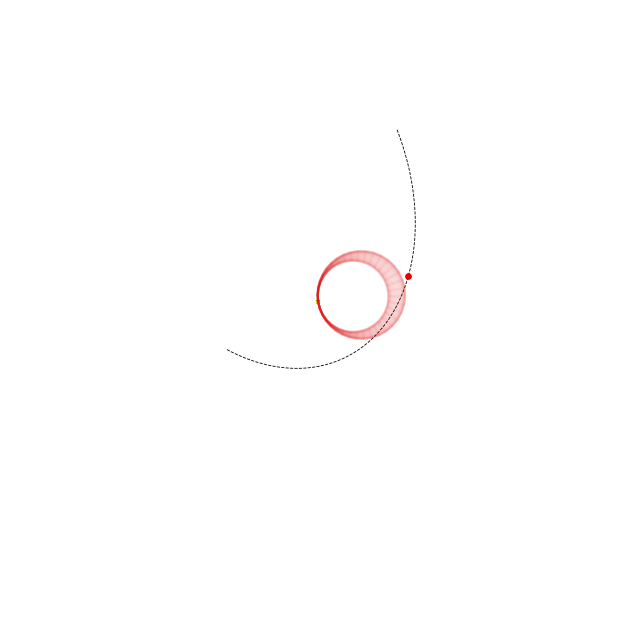

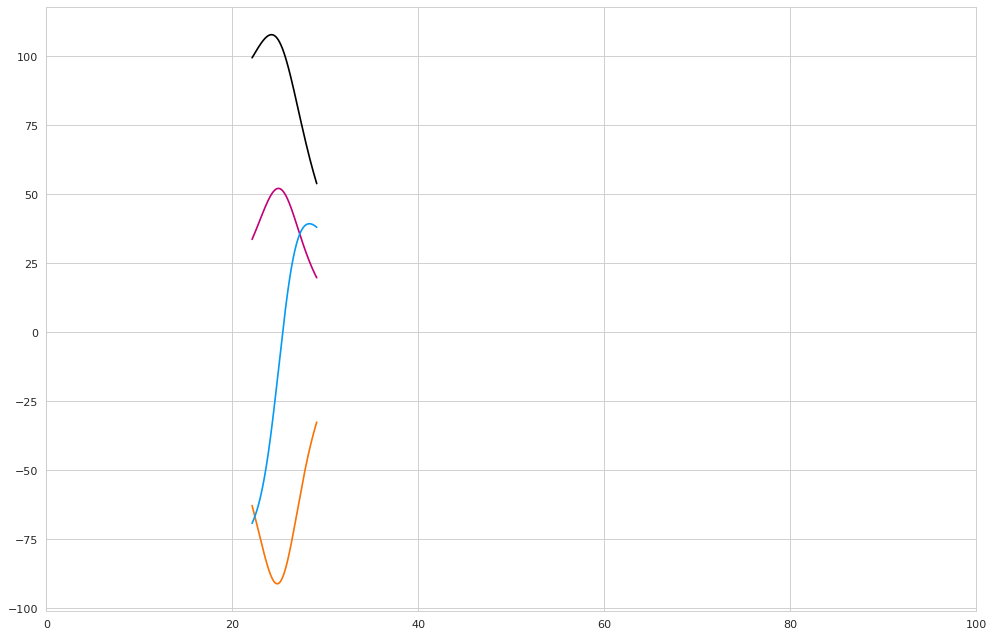

In [7]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 10),dpi=80)
ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=125, view_elev=90, view_radius=.5)
#plot_configure3(ax, view_azim=125, view_elev=90, view_radius=.2)

plot_3dcore3(ax, model_obj2, TP1, color=C_A)
#plot_3dcore_field(ax, model_obj2, color=C_A, steps=300, step_size=0.0005, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP1, frame="ECLIPJ2000", color=C_A)
plot_traj(ax, "PSP", TP1, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=300,lw=1.5)


fig = plt.figure(figsize=(15, 10),dpi=80)
ax = fig.add_subplot(111)

simtime_rt1=np.round((parse_time(rt1).plot_date-parse_time(t_launch).plot_date)*24,4)        

ax.plot(simtime_rt1, rbtot1, color=C0, label="$|B|$")
ax.plot(simtime_rt1, rbxyz1[:, 0], color=C1, label="$B_R$")
ax.plot(simtime_rt1, rbxyz1[:, 1], color=C2, label="$B_T$")
ax.plot(simtime_rt1, rbxyz1[:, 2], color=C3, label="$B_N$")
ax.set_xlim(0,100)

    